Esta primera celda, pide el nombre y el radio en arcominutos, se deja ejecutar y habrá descargado el catalogo de gaia asociado. Para que toda esta madre funcione, hay que meter dentro de una misma carpeta este codigo, el codigo de phot3.py y el archivo bash que se descarga desde tess, no hay que moverle en teoria nada a ninguno.
Lo único capaz, esque los directorios no esten funcionando, pero mientras todo esté en la misma carpeta deberia funcionar.

In [11]:
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.coordinates import Angle
import astropy.units as u
import pandas as pd
import os


Gaia.ROW_LIMIT = -1 

def get_coordinates_from_name(name):
    """
    Obtiene las coordenadas RA y DEC de un objeto por su nombre usando Simbad.
    """
    simbad = Simbad()
    result = simbad.query_object(name)
    if result is not None:
        ra = result['ra'][0]  # RA en formato horas y minutos
        dec = result['dec'][0]  # DEC en grados
        ra_hms = Angle(ra, unit=u.deg).to_string(unit=u.hourangle, sep=':', precision=7)
        dec_dms = Angle(dec, unit=u.deg).to_string(unit=u.deg, sep=':', precision=6, alwayssign=True)
        
        return ra, dec,ra_hms,dec_dms
    else:
        raise ValueError(f"No se encontraron coordenadas para el objeto {name}")

def query_gaia(ra, dec, radius_arcmin=1):
    """
    Consulta Gaia para obtener los objetos alrededor de las coordenadas dadas.
    Convierte el radio de arcominutos a grados.
    """
    # Convertir radio de arcominutos a grados
    radius_deg = radius_arcmin / 60.0  # Conversión: 1 arcmin = 1/60 grados

    try:
        # Realizar la consulta en Gaia
        job = Gaia.launch_job_async(f"""
            SELECT  ra, dec,source_id
            FROM gaiadr2.gaia_source
            WHERE CONTAINS(POINT('ICRS', ra, dec), 
                           CIRCLE('ICRS', {ra}, {dec}, {radius_deg})) = 1
        """)
        results = job.get_results()
        job2 = Gaia.launch_job_async(f"""
        SELECT ra, dec, source_id
         FROM gaiadr2.gaia_source
        WHERE ra = {ra} AND dec = {dec}
        """)

# Obtener los resultados de la consulta
        results2 = job2.get_results()
        print(results2)
        return results
    except Exception as e:
        print("Error en la consulta:", e)
        return None

# Ingresar nombre del objeto
object_name = input("Ingresa el nombre del objeto: ")

# Ingresar el radio en arcominutos
radius_arcmin = float(input("Ingresa el radio de búsqueda en arcominutos: "))

# Ingresar la ruta donde se guardará el archivo Excel
#file_path = input("Ingresa la ruta completa donde deseas guardar el archivo Excel (ejemplo: C:/Users/usuario/Documentos/gaia_results.xlsx): ")


    # Obtener coordenadas RA y DEC del objeto usando Simbad
def save_to_csv():
    ra, dec,ra_hms,dec_dms= get_coordinates_from_name(object_name)
    print(f"Coordenadas de {object_name} - RA: {ra}°, DEC: {dec}°")
    print(f"Coordenadas de {object_name} - RA_HMS: {ra_hms}, DEC_DMS: {dec_dms}")
    # Realizar la consulta en Gaia
    results = query_gaia(ra, dec, radius_arcmin=radius_arcmin)
    # Guardar los resultados en el archivo Excel
    print(f"Se hallaron {len(results)} objetos")
    data = results.to_pandas()
    data.to_csv('datos_gaia3edr.csv',index = False, header=False,sep=" ")
    rows, columns = data.shape
  
save_to_csv()


Ingresa el nombre del objeto:  algol
Ingresa el radio de búsqueda en arcominutos:  10


Coordenadas de algol - RA: 47.04221855625°, DEC: 40.95564667027778°
Coordenadas de algol - RA_HMS: 3:08:10.1324535, DEC_DMS: +40:57:20.328013
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
 ra dec source_id
deg deg          
--- --- ---------
Se hallaron 1579 objetos


In [ ]:
Esto siguiente es solamente una definición de una función, no hay que mover nada, si da problemas crear la carpeta imagenes a mano

In [360]:
import os
import subprocess
from IPython.display import clear_output
 
dest_dir ="./imagenes"
current_dir = os.getcwd()
current_folder = os.path.basename(current_dir)
print(current_dir)
if f'./{current_folder}' == dest_dir:
    print(f"Estás dentro de {current_folder}. Saliendo...")
    os.chdir("..") 

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

def ejecutar_curl_desde_archivo(archivo_sh, linea_inicio, linea_final):
    # Cambiar al directorio de destino una sola vez

    with open(archivo_sh, "r") as archivo:
        for i, linea in enumerate(archivo):
            if i < linea_inicio:  # Saltar líneas antes del inicio
                continue
            if i > linea_final:  # Terminar después de la línea final
                break

            linea = linea.strip()  # Eliminar espacios innecesarios

            # Imprimir qué comando se ejecutará
            print(f"Imagen {i} de {linea_final}")
            print(f"Ejecutando: {linea}")
            os.chdir(dest_dir)
            try:
                # Ejecutar el comando y esperar que termine
                result = subprocess.run(linea, shell=True, text=True)
            except Exception as e:
                print(f"Error al ejecutar la línea {linea}: {e}")

    # Volver al directorio original
            os.chdir("..")
            clear_output(wait=True)
# Llamar a la función con el nombre del archivo .sh, el directorio de destino y el número de líneas

Descarga de Imagenes Finalizada


Este es el loop principal, define una función que inicia en una linea y finaliza en otra del bash, eso en esencia es elegir desde que imagen a que imagen se va a descargar.
Esas imagenes se analizan con phot3.py,se generan dos carpetas, la importante es csv_out, ahi esta lo que interesa, una vez se analicen todas las que uno pone a descargar las fits se borran, entonces es importante no borrar los archivos de csv_out.

In [404]:
import os
import subprocess
import warnings
from astropy.wcs import FITSFixedWarning
#os.chdir("..")
def Descarga_y_analizis(inicio,fin):
    ejecutar_curl_desde_archivo("tesscurl_sector_18_ffic.sh",inicio, fin)
    print("Descarga de Imagenes Finalizada")
    # Ejecutar phot.py y pasar el directorio como argumento
    result = subprocess.run("python phot3.py", shell=True, capture_output=True, text=True)

    # Mostrar salida para verificar si hay algún error
    print(result.stdout)
    print(result.stderr)
    warnings.simplefilter('ignore', FITSFixedWarning)
    shutil.rmtree("./imagenes")
    os.makedirs("./imagenes", exist_ok=True)
    # Listar todos los archivos y carpetas dentro de la carpeta


In [ ]:
#La función se ejecuta tal que así, tan pronto termine debe mostrar un mensaje de: proceso completado
Descarga_y_analizis(300,400)

Imagen 377 de 400
Ejecutando: curl -C - -L -o tess2019327142925-s0018-1-4-0162-s_ffic.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019327142925-s0018-1-4-0162-s_ffic.fits


In [398]:
#Esta celñda lo que hace es buscar en la carpeta csv_out el codigo en este caso para algol, es eñ nombre del catalogo que da simbad,para gaia dr2
import os
import csv
nombre_carpeta = "csv_out"

# Obtiene el directorio actual de trabajo
directorio = os.getcwd()
directorio= os.path.basename(directorio)
if not f'{directorio}' == nombre_carpeta:
    os.chdir("./csv_out")
fechas=[]
magnitudes=[]
for archivo in os.listdir("./"):
        with open(archivo, mode='r', newline='', encoding='utf-8') as archivo_csv:
            lector = csv.reader(archivo_csv)
            # Iterar sobre las filas del CSV
            for fila in lector:
                # Acceder a cada campo en la fila
                # Si buscas un contenido específico, por ejemplo, en la primera columna
                if fila[0] == '239863001382455424':
                    print(f"Encontrado en \n{archivo}: \n{fila}")
                    fechas.append(fila[5])
                    magnitudes.append(fila[3])


Encontrado en 
DATAOUT_1791.005370569031.csv: 
['239863001382455424', '47.04222797272186', '40.95564357022187', '3.2517416', '0.00022212354', '2019-11-03T12:06:34.833']
Encontrado en 
DATAOUT_1791.088706473518.csv: 
['239863001382455424', '47.04222797272186', '40.95564357022187', '3.4399756', '0.00025096006', '2019-11-03T14:06:35.055']
Encontrado en 
DATAOUT_1800.422220475708.csv: 
['239863001382455424', '47.04222797272186', '40.95564357022187', '3.1059577', '0.00023870759', '2019-11-12T22:06:50.665']
Encontrado en 
DATAOUT_1807.234781549727.csv: 
['239863001382455424', '47.04222797272186', '40.95564357022187', '3.1093107', '0.00020465933', '2019-11-19T17:36:55.942']
Encontrado en 
DATAOUT_1813.234755695627.csv: 
['239863001382455424', '47.04222797272186', '40.95564357022187', '3.1099894', '0.00022255884', '2019-11-25T17:36:53.708']
Encontrado en 
DATAOUT_1813.359754455474.csv: 
['239863001382455424', '47.04222797272186', '40.95564357022187', '3.1040052', '0.000227527', '2019-11-25T20:

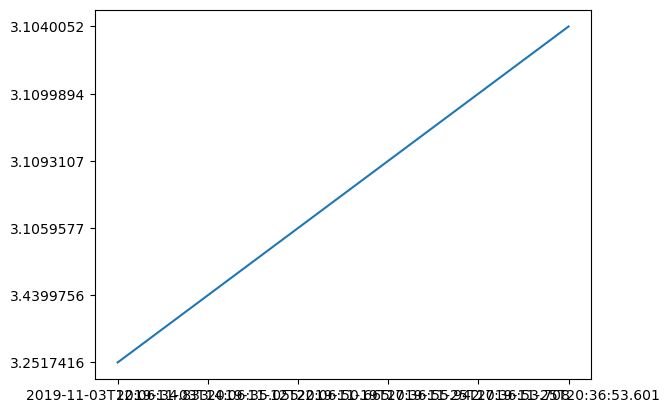

In [400]:
import matplotlib.pyplot as plt
plt.plot(fechas,magnitudes)

In [378]:
import shutil
shutil.rmtree("./imagenes")
os.makedirs("./imagenes", exist_ok=True)